# Introduction:

The Gradient Booting Machine (known as GBM, or sometimes simply Gradient Booting) is an approach of Machine Learning for both regression and classification problems. For more details about this model, please read https://en.wikipedia.org/wiki/Gradient_boosting.


In this post we will use the data set `hmeq.csv` from Credit Risk Analytics book: Measurement Techniques, Applications, and Examples in SAS. This is the data set used many times in this book for some classification models.

Our goal is based on information about customers applying for credit (occupation, loan purpose, loan amount, criminal record...) to build the model, in order to classify records for granting credit to customers.

With classification problems as just presented, `Logistic` is often the first thought model. However, the classification quality of this model is not good.

Using the GBM model, the classification results of the model achieved much higher accuracy than Logistic for the data set `hmeq.csv`. Specifically, quality classification of GBM model for test data set: (1) Accuracy is 94.43%, (2) the rate of misclassing bad records into good records (this is important) at a low level of 17.65% , (3) AUC = 0.97 (very high level according to the classification criteria for quality classification model./


Let's get started!


# Data Manipulation

In [26]:
import pandas as pd
credit = pd.read_csv("C:/Users/mlcl.local/Desktop/Self-Studied-R-and-Python/Python/hmeq.csv")

credit = credit.assign(MORTDUE = credit["MORTDUE"].fillna(credit["MORTDUE"]).mean(),
                      VALUE = credit["VALUE"].fillna(credit["VALUE"].mean()),
                      DEBTINC = credit["DEBTINC"].fillna(credit["DEBTINC"].mean()),
                      JOB = credit["JOB"].fillna("Other"),
                      REASON = credit["REASON"].fillna("Unknown"))

credit.head(10)

,BAD,LOAN,MORTDUE,VALUE,REASON,JOB,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC
0,1,1100,73760.8172,39025.000000,HomeImp,Other,10.5,0.0,0.0,94.366667,1.0,9.0,33.779915
1,1,1300,73760.8172,68400.000000,HomeImp,Other,7.0,0.0,2.0,121.833333,0.0,14.0,33.779915
2,1,1500,73760.8172,16700.000000,HomeImp,Other,4.0,0.0,0.0,149.466667,1.0,10.0,33.779915
3,1,1500,73760.8172,101776.048741,Unknown,Other,NaN,NaN,NaN,NaN,NaN,NaN,33.779915
4,0,1700,73760.8172,112000.000000,HomeImp,Office,3.0,0.0,0.0,93.333333,0.0,14.0,33.779915
5,1,1700,73760.8172,40320.000000,HomeImp,Other,9.0,0.0,0.0,101.466002,1.0,8.0,37.113614
6,1,1800,73760.8172,57037.000000,HomeImp,Other,5.0,3.0,2.0,77.100000,1.0,17.0,33.779915
7,1,1800,73760.8172,43034.000000,HomeImp,Other,11.0,0.0,0.0,88.766030,0.0,8.0,36.884894
8,1,2000,73760.8172,46740.000000,HomeImp,Other,3.0,0.0,2.0,216.933333,1.0,12.0,33.779915
9,1,2000,73760.8172,62250.000000,HomeImp,Sales,16.0,0.0,0.0,115.800000,0.0,13.0,33.779915


In [27]:
# Re-label for BAD and drop NAs:

df = credit.dropna(how = "any", axis = 0)
df2 = df.assign(BAD = df["BAD"].map(lambda x: "B" if x == 1 else "G"))
df2.head()

,BAD,LOAN,MORTDUE,VALUE,REASON,JOB,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC
0,B,1100,73760.8172,39025.0,HomeImp,Other,10.5,0.0,0.0,94.366667,1.0,9.0,33.779915
1,B,1300,73760.8172,68400.0,HomeImp,Other,7.0,0.0,2.0,121.833333,0.0,14.0,33.779915
2,B,1500,73760.8172,16700.0,HomeImp,Other,4.0,0.0,0.0,149.466667,1.0,10.0,33.779915
4,G,1700,73760.8172,112000.0,HomeImp,Office,3.0,0.0,0.0,93.333333,0.0,14.0,33.779915
5,B,1700,73760.8172,40320.0,HomeImp,Other,9.0,0.0,0.0,101.466002,1.0,8.0,37.113614


# GBM default

In [28]:
# Loading h2o:
import h2o 

h2o.init(nthreads = 2, max_mem_size = 6)

Checking whether there is an H2O instance running at http://localhost:54321. connected.


H2O cluster uptime:,14 mins 22 secs
H2O cluster timezone:,Australia/Sydney
H2O data parsing timezone:,UTC
H2O cluster version:,3.22.1.1
H2O cluster version age:,13 days
H2O cluster name:,H2O_from_python_mlcl_local_5p2sq8
H2O cluster total nodes:,1
H2O cluster free memory:,5.274 Gb
H2O cluster total cores:,4
H2O cluster allowed cores:,2
H2O cluster status:,"locked, healthy"


In [30]:
# Transform to h2o objects:

df = h2o.H2OFrame(df2)

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [31]:
# Declare input output:

response = "BAD"
predictors = df.names
predictors.remove("BAD")

In [40]:
# Split dataset:

train, test = df.split_frame(ratios = [0.8], seed = 1234)

In [41]:
# Use GBM and cross-validation with k folds = 5:

from h2o.estimators.gbm import H2OGradientBoostingEstimator

cv_gbm = H2OGradientBoostingEstimator(nfolds = 5, seed = 31)
cv_gbm.train(x = predictors, y = response, training_frame = train)

gbm Model Build progress: |███████████████████████████████████████████████| 100%


In [42]:
cv_gbm

Model Details
H2OGradientBoostingEstimator :  Gradient Boosting Machine
Model Key:  GBM_model_python_1547088769622_1708


ModelMetricsBinomial: gbm
** Reported on train data. **

MSE: 0.05116043399327827
RMSE: 0.2261867237334638
LogLoss: 0.18758693234655005
Mean Per-Class Error: 0.08550761851578548
AUC: 0.9708696475937856
pr_auc: 0.9894643254558677
Gini: 0.9417392951875712
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.598685583197086: 


,B,G,Error,Rate
B,653.0,145.0,0.1817,(145.0/798.0)
G,106.0,2910.0,0.0351,(106.0/3016.0)
Total,759.0,3055.0,0.0658,(251.0/3814.0)


Maximum Metrics: Maximum metrics at their respective thresholds



metric,threshold,value,idx
max f1,0.5986856,0.9586559,205.0
max f2,0.2865849,0.9776681,293.0
max f0point5,0.7626578,0.9632272,154.0
max accuracy,0.5986856,0.9341898,205.0
max precision,0.9838227,1.0,0.0
max recall,0.2474306,1.0,305.0
max specificity,0.9838227,1.0,0.0
max absolute_mcc,0.6145266,0.7980804,201.0
max min_per_class_accuracy,0.8140855,0.9135338,139.0
max mean_per_class_accuracy,0.8105269,0.9144924,140.0


Gains/Lift Table: Avg response rate: 79.08 %, avg score: 79.06 %



,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain
,1,0.0102255,0.9810244,1.2645889,1.2645889,1.0,0.9819439,1.0,0.9819439,0.0129310,0.0129310,26.4588859,26.4588859
,2,0.0201888,0.9801408,1.2645889,1.2645889,1.0,0.9807327,1.0,0.9813462,0.0125995,0.0255305,26.4588859,26.4588859
,3,0.0304143,0.9790739,1.2321635,1.2536872,0.9743590,0.9794616,0.9913793,0.9807126,0.0125995,0.0381300,23.2163504,25.3687231
,4,0.0401154,0.9778188,1.2645889,1.2563236,1.0,0.9784489,0.9934641,0.9801651,0.0122679,0.0503979,26.4588859,25.6323573
,5,0.0506030,0.9764427,1.2645889,1.2580366,1.0,0.9771412,0.9948187,0.9795384,0.0132626,0.0636605,26.4588859,25.8036586
,6,0.1001573,0.9734600,1.2645889,1.2612784,1.0,0.9747559,0.9973822,0.9771722,0.0626658,0.1263263,26.4588859,26.1278417
,7,0.1504982,0.9708680,1.2580025,1.2601826,0.9947917,0.9720533,0.9965157,0.9754599,0.0633289,0.1896552,25.8002459,26.0182626
,8,0.2003146,0.9682972,1.2645889,1.2612784,1.0,0.9695983,0.9973822,0.9740022,0.0629973,0.2526525,26.4588859,26.1278417
,9,0.3007341,0.9624318,1.2579853,1.2601788,0.9947781,0.9653304,0.9965126,0.9711066,0.1263263,0.3789788,25.7985262,26.0178785
,10,0.4001049,0.9528341,1.2612522,1.2604454,0.9973615,0.9580717,0.9967235,0.9678692,0.1253316,0.5043103,26.1252213,26.0445383




ModelMetricsBinomial: gbm
** Reported on cross-validation data. **

MSE: 0.07158431513849717
RMSE: 0.26755245306013764
LogLoss: 0.24626592934541158
Mean Per-Class Error: 0.13248306442498814
AUC: 0.9351275237164529
pr_auc: 0.9764439688102432
Gini: 0.8702550474329058
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5256511367822604: 


,B,G,Error,Rate
B,534.0,264.0,0.3308,(264.0/798.0)
G,98.0,2918.0,0.0325,(98.0/3016.0)
Total,632.0,3182.0,0.0949,(362.0/3814.0)


Maximum Metrics: Maximum metrics at their respective thresholds



metric,threshold,value,idx
max f1,0.5256511,0.9415941,241.0
max f2,0.2959079,0.9681285,302.0
max f0point5,0.7471220,0.9435243,172.0
max accuracy,0.5256511,0.9050865,241.0
max precision,0.9776142,0.9962406,11.0
max recall,0.0664210,1.0,373.0
max specificity,0.9893618,0.9987469,0.0
max absolute_mcc,0.7471220,0.7082607,172.0
max min_per_class_accuracy,0.8428616,0.8621554,131.0
max mean_per_class_accuracy,0.7471220,0.8675169,172.0


Gains/Lift Table: Avg response rate: 79.08 %, avg score: 79.52 %



,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain
,1,0.0102255,0.9834204,1.2321635,1.2321635,0.9743590,0.9850821,0.9743590,0.9850821,0.0125995,0.0125995,23.2163504,23.2163504
,2,0.0201888,0.9816991,1.2645889,1.2481656,1.0,0.9826163,0.9870130,0.9838652,0.0125995,0.0251989,26.4588859,24.8165627
,3,0.0301521,0.9802674,1.2645889,1.2535924,1.0,0.9810126,0.9913043,0.9829226,0.0125995,0.0377984,26.4588859,25.3592435
,4,0.0401154,0.9793507,1.2645889,1.2563236,1.0,0.9797053,0.9934641,0.9821235,0.0125995,0.0503979,26.4588859,25.6323573
,5,0.0500787,0.9786270,1.2645889,1.2579680,1.0,0.9789744,0.9947644,0.9814970,0.0125995,0.0629973,26.4588859,25.7967975
,6,0.1001573,0.9755280,1.2579680,1.2579680,0.9947644,0.9769519,0.9947644,0.9792244,0.0629973,0.1259947,25.7967975,25.7967975
,7,0.1499738,0.9727846,1.2579331,1.2579564,0.9947368,0.9741983,0.9947552,0.9775549,0.0626658,0.1886605,25.7933129,25.7956400
,8,0.2000524,0.9699777,1.2447262,1.2546445,0.9842932,0.9712673,0.9921363,0.9759810,0.0623342,0.2509947,24.4726207,25.4644517
,9,0.2999476,0.9626944,1.2479932,1.2524294,0.9868766,0.9664714,0.9903846,0.9728139,0.1246684,0.3756631,24.7993205,25.2429351
,10,0.4001049,0.9535175,1.2480366,1.2513297,0.9869110,0.9583359,0.9895151,0.9691896,0.125,0.5006631,24.8036649,25.1329736



Cross-Validation Metrics Summary: 


,mean,sd,cv_1_valid,cv_2_valid,cv_3_valid,cv_4_valid,cv_5_valid
accuracy,0.9100817,0.0049087,0.9163399,0.9163545,0.9040207,0.8996089,0.9140845
auc,0.9364685,0.0068637,0.9412085,0.9400579,0.929378,0.9219798,0.9497184
err,0.0899183,0.0049087,0.0836601,0.0836454,0.0959793,0.1003911,0.0859155
err_count,68.6,4.256759,64.0,67.0,74.0,77.0,61.0
f0point5,0.9340965,0.0059330,0.9363178,0.9351318,0.9252218,0.9256927,0.9481184
f1,0.9441688,0.0029453,0.9488818,0.9485012,0.9404187,0.9385475,0.944495
f2,0.9545665,0.0055532,0.9617876,0.9622583,0.9561231,0.9517644,0.9408992
lift_top_group,1.2337663,0.0500887,1.09375,1.2614173,1.2764901,1.253268,1.283906
logloss,0.2462852,0.0098747,0.2336053,0.2333562,0.2536148,0.2700257,0.2408241
max_per_class_error,0.2866195,0.0422172,0.3006536,0.2951807,0.3233533,0.3419355,0.1719745


Scoring History: 


,timestamp,duration,number_of_trees,training_rmse,training_logloss,training_auc,training_pr_auc,training_lift,training_classification_error
,2019-01-10 14:08:58,2.131 sec,0.0,0.4067583,0.5129336,0.5,0.0,1.0,0.2092292
,2019-01-10 14:08:58,2.131 sec,1.0,0.3886432,0.4729165,0.8144742,0.9040636,1.2415963,0.1143157
,2019-01-10 14:08:58,2.131 sec,2.0,0.3726115,0.4413416,0.8915928,0.9566501,1.2397930,0.1069743
,2019-01-10 14:08:58,2.146 sec,3.0,0.3581879,0.4146940,0.9131460,0.9713468,1.2645889,0.1072365
,2019-01-10 14:08:58,2.146 sec,4.0,0.3478912,0.3972802,0.9150250,0.9715169,1.2645889,0.1040902
---,---,---,---,---,---,---,---,---,---
,2019-01-10 14:08:59,2.542 sec,46.0,0.2311114,0.1945776,0.9682325,0.9892773,1.2645889,0.0700052
,2019-01-10 14:08:59,2.557 sec,47.0,0.2303320,0.1934036,0.9685842,0.9893279,1.2645889,0.0697431
,2019-01-10 14:08:59,2.557 sec,48.0,0.2288453,0.1914777,0.9692860,0.9894892,1.2645889,0.0679077
,2019-01-10 14:08:59,2.573 sec,49.0,0.2279928,0.1901619,0.9696404,0.9896527,1.2645889,0.0668589



See the whole table with table.as_data_frame()
Variable Importances: 


variable,relative_importance,scaled_importance,percentage
DEBTINC,942.0360107,1.0,0.4285785
DELINQ,455.2504578,0.4832623,0.2071158
CLAGE,157.5641937,0.1672592,0.0716837
VALUE,135.5544891,0.1438952,0.0616704
DEROG,126.0688324,0.1338259,0.0573549
NINQ,95.2972488,0.1011609,0.0433554
LOAN,91.5013657,0.0971315,0.0416285
YOJ,61.8996735,0.0657084,0.0281612
CLNO,60.3914261,0.0641073,0.0274750
JOB,51.4410477,0.0546062,0.0234031


In [43]:
# Model summary:

cv_summary = cv_gbm.cross_validation_metrics_summary().as_data_frame()
cv_summary

,,mean,sd,cv_1_valid,cv_2_valid,cv_3_valid,cv_4_valid,cv_5_valid
0,accuracy,0.9100817,0.004908678,0.9163399,0.91635454,0.9040207,0.89960885,0.9140845
1,auc,0.9364685,0.006863742,0.9412085,0.9400579,0.929378,0.9219798,0.9497184
2,err,0.08991829,0.004908678,0.08366013,0.08364544,0.09597925,0.100391135,0.08591549
3,err_count,68.6,4.256759,64.0,67.0,74.0,77.0,61.0
4,f0point5,0.9340965,0.005932987,0.9363178,0.93513185,0.9252218,0.9256927,0.9481184
5,f1,0.9441688,0.0029453442,0.9488818,0.94850117,0.94041866,0.9385475,0.944495
6,f2,0.9545665,0.005553173,0.9617876,0.9622583,0.9561231,0.95176435,0.9408992
7,lift_top_group,1.2337663,0.050088685,1.09375,1.2614173,1.2764901,1.253268,1.283906
8,logloss,0.24628523,0.009874692,0.23360533,0.23335625,0.25361478,0.27002573,0.24082409
9,max_per_class_error,0.2866195,0.042217236,0.3006536,0.2951807,0.3233533,0.3419355,0.17197452


## Model performance on test data

In [44]:
# Model performance on test data:
perf_cv_test = cv_gbm.model_performance(test)

In [45]:
# AUC on testdata:
perf_cv_test.auc()

0.9478612677947891

In [47]:
# Gini:
perf_cv_test.gini()

0.8957225355895782

In [49]:
# Confusion matrix:

perf_cv_test.confusion_matrix()

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.6433010744873227: 


,B,G,Error,Rate
B,164.0,40.0,0.1961,(40.0/204.0)
G,39.0,691.0,0.0534,(39.0/730.0)
Total,203.0,731.0,0.0846,(79.0/934.0)


In [50]:
# Accuracy of model on test data:

1-0.0846

0.9154

Although the model delivered 91.54% accuracy and Gini indicator is high, this default GBM forecasts false 40 bad records (label B) into good records (label G) equivalent to ~ 20% error. 
Miss clasification of good and bad records the banks can lose an opportunity to make a profit, but misleading bad records into good records is much more severe for financial institutions.
So we need to improve the default GBM.

# Refining GBM

In [51]:
# Setup parameters for GBM:

gbm_tuned = H2OGradientBoostingEstimator(

    # number of ntree:
    ntrees = 10000,
    
    # Learning rate 
    learn_rate = 0.01,
    
    # Stop the algorithm early if the AUC validation does not improve 
    # at least 0.01% after 5 attempts
    stopping_rounds = 5, stopping_tolerance = 1e-04, stopping_metric = "AUC",
    
    # For each tree, input 80% variables:
    sample_rate = 0.8,
    
    # 80% of variables for every split:
    col_sample_rate = 0.8,
    
    # samples selection must ensure that the ratio of profile labels is preserved
    fold_assignment = "Stratified",
    
    # regenerate the results:
    seed = 1234,
    score_tree_interval = 10,
    
    # Cross validation with k = 5:
    
    nfolds = 5)

In [52]:
# Tune the model:

gbm_tuned.train(x = predictors, y = response, training_frame = train)

gbm Model Build progress: |███████████████████████████████████████████████| 100%


In [53]:
# Model performance on test data:

perf_for_test = gbm_tuned.model_performance(test)

In [54]:
# Confusion matrix:

perf_for_test.confusion_matrix()

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5724966274825194: 


,B,G,Error,Rate
B,167.0,37.0,0.1814,(37.0/204.0)
G,20.0,710.0,0.0274,(20.0/730.0)
Total,187.0,747.0,0.061,(57.0/934.0)


In [55]:
# AUC:
perf_for_test.auc()

0.9656392694063927

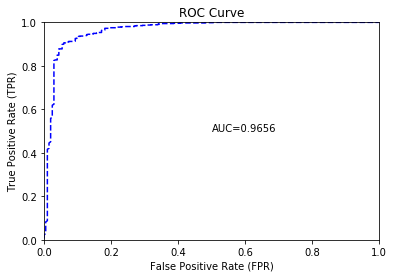

In [57]:
# Visualise AUC:

perf_for_test.plot()

In [58]:
# Gini:
perf_for_test.gini()

0.9312785388127853

In [61]:
# Accuracy on testdata:
1-0.061

0.9390000000000001

# Evaluate models on 30 different samples

tobe continued....